In [1]:
from Network import Generator, Discriminator
import Utils
from keras.applications.vgg19 import VGG19

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Lambda, Add, Concatenate
from keras.optimizers import Adam
from keras.layers.core import Activation
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.normalization import BatchNormalization
from keras.models import load_model

from skimage import data, io
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm, tqdm_notebook
import numpy as np

Using TensorFlow backend.


In [2]:
# how many times the original image is scaled down
downscale_factor = 4
# expected output size
output_image_shape = (1920,1080,3)

input_image_shape = (480,270,3)

## Res block

In [3]:
def res_block_gen(model, kernal_size, filters, strides):
    
    gen = model
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
        
    model = Add()([gen, model])
    
    return model

## Upsampling block

In [4]:
def up_sampling_block(model, kernal_size, filters, strides):
    
    model = Conv2DTranspose(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = LeakyReLU(alpha = 0.2)(model)
    #model = PReLU(shared_axes=[1,2,3])(model)
    
    return model

## Loss function

In [5]:
class VGG_MSE_LOSS(object):

    def __init__(self, image_shape, orig_rate = 0.1):
        
        self.image_shape = image_shape
        self.orig_rate = orig_rate

    # computes VGG loss or content loss
    def loss(self, y_true, y_pred):
    
        vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=self.image_shape)
        vgg19.trainable = False
        # Make trainable as False
        for l in vgg19.layers:
            l.trainable = False
        model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
        model.trainable = False
        
        return K.mean(K.square(model(y_true) - model(y_pred))) + self.orig_rate * K.mean(K.square(y_true - y_pred))

In [6]:
class VGG_LOSS(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape

    # computes VGG loss or content loss
    def loss(self, y_true, y_pred):
    
        vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=self.image_shape)
        vgg19.trainable = False
        # Make trainable as False
        for l in vgg19.layers:
            l.trainable = False
        model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
        model.trainable = False
        
        return K.mean(K.square(model(y_true) - model(y_pred)))

## Generator

In [7]:
def make_generator(input_shape):
        
    gen_input = Input(shape = input_image_shape)

    model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
    model = PReLU(shared_axes=[1,2])(model)

    gen_model = model

    for index in range(16):
        model = res_block_gen(model, 3, 64, 1)

    model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = Add()([gen_model, model])

    for index in range(2):
        model = up_sampling_block(model, 3, 192, 2)
    
    # resized_input = K.resize_images(gen_input, 4, 4, "channels_last", "bilinear")
    resized_input = (Lambda(lambda x: K.resize_images(x, 4, 4, "channels_last", "bilinear")))(gen_input)
    model = Concatenate(axis = 3)([resized_input, model])

    model = Conv2D(filters = 3, kernel_size = 9, strides = 1, padding = "same")(model)
    model = Activation('tanh')(model)

    generator_model = Model(inputs = gen_input, outputs = model)

    return generator_model

## Data

In [8]:
input_dir = '../images/photo_fullhd'
model_save_dir = 'trained_model'
number_of_images = 1000
train_test_ratio = 0.8

epochs = 5
batch_count = 10001
batch_size = 1

In [9]:
x_train_lr, x_train_hr, x_test_lr, x_test_hr = Utils.load_training_data(input_dir, '.jpg', number_of_images, train_test_ratio, downscale_factor, prog_func=tqdm_notebook) 

## Model

In [10]:
generator = make_generator(input_image_shape)

W0920 22:35:10.998002 139974287677248 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0920 22:35:11.014389 139974287677248 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0920 22:35:11.017342 139974287677248 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0920 22:35:11.060826 139974287677248 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:17

In [11]:
input_layer = Input(shape=input_image_shape)
upscaled_layer = generator(input_layer)

upscale_model = Model(inputs=input_layer, outputs=upscaled_layer)

In [12]:
#upscale_model.compile(loss="mean_squared_error", optimizer=Adam())

In [13]:
vgg_loss = VGG_MSE_LOSS(output_image_shape, 0.01).loss

In [14]:
upscale_model.compile(loss=vgg_loss, optimizer=Adam())

W0920 22:35:17.918556 139974287677248 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0920 22:35:17.945711 139974287677248 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [18]:
agg_loss = None
loss_update_rate = 0.01

loss_file = open(model_save_dir + '/losses.txt' , 'w+')
loss_file.write('batch\tloss\tagg_loss\n')
loss_file.close()

for b in tqdm_notebook(range(batch_count)):

    rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
    #rand_nums = [2]

    image_batch_hr = x_train_hr[rand_nums]
    image_batch_lr = x_train_lr[rand_nums]
    loss = upscale_model.train_on_batch(image_batch_lr, image_batch_hr)

    if(agg_loss == None):
        agg_loss = loss
    else:
        agg_loss = (1 - loss_update_rate) * agg_loss + loss_update_rate * loss

    loss_file = open(model_save_dir + '/losses.txt' , 'a')
    loss_file.write('%d\t%f\t%f\n' %(b, loss, agg_loss) )
    loss_file.close()

    #if(b % 10 == 0):
    #    print ('Batch: %d,' % b, ' Agg loss %f' % agg_loss)
    
    if(b % 1000 == 0):
        upscale_model.compile(loss="mean_squared_error", optimizer=Adam()) # so it'll be easy to load the model
        upscale_model.save('trained_model/upscale_model_skip_con_%db.h5' % b)
        upscale_model.compile(loss=vgg_loss, optimizer=Adam())

KeyboardInterrupt: 

## Saving a model

In [67]:
upscale_model.compile(loss="mean_squared_error", optimizer=Adam()) # so it'll be easy to load the model
upscale_model.save('trained_model/upscale_model_skip_con_1001b.h5')

## Loading a model

In [14]:
upscale_model = load_model('trained_model/upscale_model_skip_con_1001b.h5')
upscale_model.compile(loss=vgg_loss, optimizer=Adam())

W0920 22:17:43.014927 140595912423232 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0920 22:17:43.070942 140595912423232 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



## Results save

In [51]:
def save_array_as_image(a, filename):
    a = np.uint8(np.around((a + 1) * 127.5))
    a = np.swapaxes(a, 0, 1)
    a_img = Image.fromarray(a)
    a_img.save("example_images/skip_con_" + filename, quality = 100)

In [39]:
def rescale_save_array_as_image(a, filename):
    a = np.uint8(np.around((a + 1) * 127.5))
    a = np.swapaxes(a, 0, 1)
    a_img = Image.fromarray(a)
    a_img = a_img.resize((1920, 1080), Image.BICUBIC)
    a_img.save("example_images/skip_con_" + filename, quality = 100)

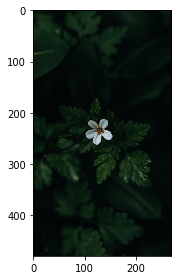

In [52]:
ex = x_train_lr[2]
rescale_save_array_as_image(ex, "train_lowres.jpg")

ex = (ex + 1)/2
#ex = ex.swapaxes(0,1)

io.imshow(ex)

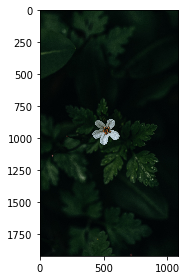

In [41]:
ex = x_train_hr[2]
rescale_save_array_as_image(ex, "train_orig.jpg")

ex = (ex + 1)/2
#ex = ex.swapaxes(0,1)

io.imshow(ex)

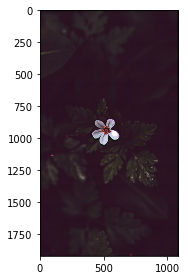

In [66]:
ex = upscale_model.predict(x_train_lr[[2]])[0]
rescale_save_array_as_image(ex, "train_upscaled.jpg")

ex = (ex + 1)/2

io.imshow(ex)

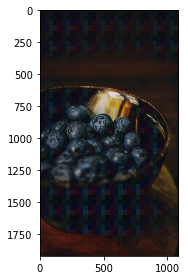

In [43]:
ex = upscale_model.predict(x_test_lr[[0]])[0]
save_array_as_image(ex, "test_upscaled.jpg")

ex = (ex + 1)/2

io.imshow(ex)

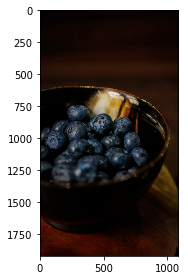

In [44]:
ex = x_test_hr[0]
save_array_as_image(ex, "test_orig.jpg")

ex = (ex + 1)/2
#ex = ex.swapaxes(0,1)

io.imshow(ex)

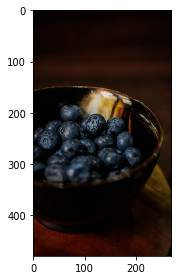

In [45]:
ex = x_test_lr[0]
rescale_save_array_as_image(ex, "test_lowres.jpg")

ex = (ex + 1)/2
#ex = ex.swapaxes(0,1)

io.imshow(ex)